In [2]:
import numpy as np
import pandas as pd

In [97]:
def dim_matrix(matrix):
    return len(matrix),len(matrix[0])

def diag_to_matrix(array):
    length = len(array)
    matrix = np.zeros([length,length])

    for row in range(0, length):
        matrix[row][row] = array[row]

    return matrix

In [98]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [99]:
state_adj_data  = pd.read_excel( "C:/Users/michelj8/Documents/GitHub/Dynamic-MESS/state_matrix.xlsx")
state_adj_data = state_adj_data.set_index('Index State')

In [100]:
adj_matrix = pd.DataFrame(columns = states)
adj_matrix.loc['AK'] = 0.0

for state in states:
    neighbors =  state_adj_data.loc[state].dropna().values
    for neighbor in neighbors:
        adj_matrix.loc[state,neighbor] =  1.0
        
adj_matrix = adj_matrix.fillna(0)
adj_matrix
adj_matrix = adj_matrix.div(adj_matrix.sum(axis =1), axis = 0).fillna(0)

In [101]:
great_lakes = ['IL','IN','OH','MI','WI']

In [102]:
cig_data = pd.read_excel( "C:/Users/michelj8/Documents/GitHub/Dynamic-MESS/cig_tax_cdc.xlsx")
great_lakes_data = cig_data[ cig_data['LocationAbbr'].isin(great_lakes)]

In [144]:
dynamic_spatial_data =  np.log(pd.pivot_table(great_lakes_data, index = 'LocationAbbr',columns = 'Year', values = 'Data_Value')).diff(axis = 1)[range(1971,2019)]

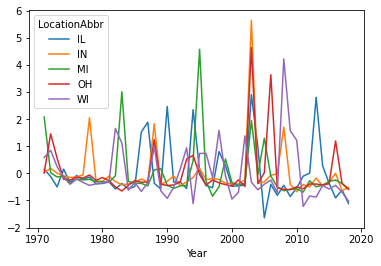

In [145]:
spatial_df = dynamic_spatial_data.copy()

series_means = spatial_df.mean(axis = 1)
normalized_spatial_df = spatial_df.copy()
normalized_spatial_df = normalized_spatial_df.sub(series_means, axis = 0)
series_sd = normalized_spatial_df.std(axis = 1)
normalized_spatial_df = normalized_spatial_df.div(series_sd, axis = 0)
year_list = normalized_spatial_df.columns

pd.pivot_table( normalized_spatial_df.reset_index(), columns = 'LocationAbbr').plot()

In [146]:
gl_weight_matrix = adj_matrix.loc[great_lakes][great_lakes]
gl_weight_matrix = gl_weight_matrix.div(gl_weight_matrix.sum(axis=1),axis=0)

In [147]:
def forecast_k_ahead(theta, k, spatial_df, w_matrix):
    no_series = len(spatial_df)
    
    #In this section we normalize the data to be forecasted, giving it mean 0 and s.d. 1
    series_means = spatial_df.mean(axis = 1)
    normalized_spatial_df = spatial_df.copy()
    normalized_spatial_df = normalized_spatial_df.sub(series_means, axis = 0)
    series_sd = normalized_spatial_df.std(axis = 1)
    normalized_spatial_df = normalized_spatial_df.div(series_sd, axis = 0)
    
#     alpha = np.array(theta[0:8]).reshape([8,1])
    rho = theta[0]
    phi = theta[1]
    lam = theta[2]
    
    id_matrix = diag_to_matrix(no_series*[1])
    aux_matrix = rho* id_matrix + phi * w_matrix
    s_matrix = id_matrix - lam*w_matrix
    
    s_inv_matrix = np.linalg.inv(s_matrix)
    m_theta_matrix = np.dot(s_inv_matrix, aux_matrix)
    
    forecast_array = normalized_spatial_df.copy()
    for k_ahead in range(0,k):
        forecast_array = np.dot(m_theta_matrix, forecast_array)

    forecast_df = pd.DataFrame(forecast_array)
    forecast_df['LocationAbbr'] = great_lakes
    forecast_df = forecast_df.set_index('LocationAbbr')
    forecast_df = forecast_df.mul(series_sd, axis =0).add(series_means, axis =0 )
    forecast_df.columns = spatial_df.columns + k
    
    return forecast_df

In [148]:
def forecast_errors_k_ahead(theta,k, spatial_df, w_matrix):
    forecast_df = forecast_k_ahead(theta,k,spatial_df,w_matrix)
    
    data_years = list(spatial_df.columns)
    forecast_years = list(forecast_df.columns)
    overlap_years = [x for x in data_years if x in forecast_years]
    
    errors = forecast_df[overlap_years]-spatial_df[overlap_years]
    return errors

In [149]:
def sse_k_ahead(theta,k,spatial_df, w_matrix):
    error_df = forecast_errors_k_ahead(theta,k,spatial_df,w_matrix)
    return np.square(error_df).sum().sum()

In [155]:
import itertools
first_year = 1971
last_year_out = 2019
k = 1
weight_matrix = gl_weight_matrix

def data_sse_k_ahead(theta,k,min_year, max_year,w_matrix):
    return sse_k_ahead(theta,k,dynamic_spatial_data[range(min_year,max_year)], w_matrix)

min_theta = [0,0,0]
min_errors = data_sse_k_ahead(min_theta,k,first_year, last_year_out, weight_matrix)

rho_grid = np.linspace(0,.1,10)
phi_grid = np.linspace(0,.1,10)
lam_grid = np.linspace(0,.1,10)

for theta in itertools.product(rho_grid, phi_grid, lam_grid):
    errors = data_sse_k_ahead(theta,k,first_year, last_year_out, weight_matrix)
    if errors < min_errors:
        min_theta = theta
        min_errors = errors
        
print(min_theta)
print( sse_k_ahead(min_theta,1,dynamic_spatial_data,weight_matrix ) )
print( sse_k_ahead([0,0,0],1,dynamic_spatial_data,weight_matrix ) )

(0.044444444444444446, 0.0, 0.0)
4.524033019543885
4.530979574314222


In [156]:
from statsmodels.tsa.arima_model import ARMA

ar_df = pd.DataFrame(columns = ['alpha','rho'])
sse = 0

for region in great_lakes:
    region_series = dynamic_spatial_data.loc[region].values
    model = ARMA(region_series, (1,0)).fit()
    ar_df.loc[region] = model.params
    sse = sse + np.square(region_series - model.predict()).sum()
    
print(sse)

4.605250293709557


In [157]:
ar_df

,alpha,rho
IL,0.031106,0.098624
IN,0.046418,-0.063223
OH,0.040486,-0.042189
MI,0.048178,0.071582
WI,0.045958,0.189641
